In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn import model_selection
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [ ]:
# global variables

INPUT_SHAPE_X = 128
INPUT_SHAPE_Y = 64
ITERATION = '3'
EPOCHS = 1000
BATCH_SIZE = 20

max_images = 1400 # max images per class

In [ ]:
# load labels
csv_path = 'labels_preprocessed.csv'
labels = pd.read_csv(csv_path)
# replace NaN values with 0s
labels.fillna(0, inplace=True)

In [ ]:
# load the images
whiskers_path = 'muzzle'
whiskers_dir = os.listdir(whiskers_path)
x_whiskers = []
y_whiskers = []
i = 0
class_0 = 0
class_1 = 0
class_2 = 0

# iterate over images
for image in whiskers_dir:
    # load the image
    image_path = os.path.join(whiskers_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # preprocess the image
    if (img is not None):
    
        # check image class
        image_class = labels.loc[labels['imageid'] == image, 'whiskers_position']

        if not image_class.empty:
            image_class = image_class.iloc[0]    
            
            # append an equal number of images from each class
            if (image_class == 0.0 and class_0 < max_images):
                x_whiskers.append(img)
                y_whiskers.append(image_class)
                class_0 += 1
                if (i == max_images*3):
                    break
                i+=1
                
                
            elif (image_class == 1.0 and class_1 < max_images):
                x_whiskers.append(img)
                y_whiskers.append(image_class)
                class_1 += 1
                if (i == max_images*3):
                    break
                i+=1
                
                
            elif (image_class == 2.0 and class_2 < max_images):
                x_whiskers.append(img)
                y_whiskers.append(image_class)
                class_2 += 1
                if (i == max_images*3):
                    break
                i+=1
  


In [ ]:
# add flipped images from class 2
flipped_path = 'muzzle-flipped'
for image in os.listdir(flipped_path):
    image_path = os.path.join(flipped_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_whiskers.append(img)
    y_whiskers.append(2)
    class_2 += 1

In [ ]:
# add augmented images from class 2
aug_path = 'muzzle-augmented'
for image in os.listdir(aug_path):
    image_path = os.path.join(aug_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_whiskers.append(img)
    y_whiskers.append(2)
    class_2 += 1

In [ ]:
print(class_0, class_1, class_2)

1400 1400 1452


In [ ]:
# preprocess
x_whiskers = tf.keras.applications.vgg16.preprocess_input(np.array(x_whiskers))

# split the dataset into train and test sets
x_train_val, x_test, y_train_val, y_test = model_selection.train_test_split(
    x_whiskers, y_whiskers, test_size=0.2, random_state=42)

# split the train and validation sets
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x_train_val, y_train_val, test_size=0.2, random_state=42)

# one-hot code labels
y_train = tf.one_hot(y_train,3)
y_val = tf.one_hot(y_val,3)
y_test = tf.one_hot(y_test,3)

In [ ]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.applications.vgg16.VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                                            include_top=False,
                                            input_shape=(INPUT_SHAPE_X, INPUT_SHAPE_Y, 3)))
model.add(tf.keras.layers.Flatten(input_shape=model.output_shape[1:]))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [ ]:
# compile the model
earlystop = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 2, 512)         14714688  
                                                                 
 flatten_12 (Flatten)        (None, 4096)              0         
                                                                 
 dense_46 (Dense)            (None, 256)               1048832   
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_47 (Dense)            (None, 128)               32896     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_48 (Dense)            (None, 3)               

In [ ]:
# train the model
hist = model.fit(x_train, y_train, 
              epochs = EPOCHS,
              batch_size = BATCH_SIZE, 
              validation_data = (x_val, y_val),
              callbacks = [earlystop])

Epoch 1/1000
136/136 [==============================] - 11s 68ms/step - loss: 1.3393 - accuracy: 0.3978 - val_loss: 1.0055 - val_accuracy: 0.4126
Epoch 2/1000
136/136 [==============================] - 9s 66ms/step - loss: 1.0348 - accuracy: 0.4118 - val_loss: 0.9901 - val_accuracy: 0.4479
Epoch 3/1000
136/136 [==============================] - 9s 66ms/step - loss: 1.0133 - accuracy: 0.4320 - val_loss: 0.9816 - val_accuracy: 0.4493
Epoch 4/1000
136/136 [==============================] - 9s 66ms/step - loss: 0.9948 - accuracy: 0.4449 - val_loss: 0.9593 - val_accuracy: 0.4640
Epoch 5/1000
136/136 [==============================] - 9s 66ms/step - loss: 0.9834 - accuracy: 0.4559 - val_loss: 0.9627 - val_accuracy: 0.4596
Epoch 6/1000
136/136 [==============================] - 9s 65ms/step - loss: 0.9742 - accuracy: 0.4827 - val_loss: 0.9569 - val_accuracy: 0.4670
Epoch 7/1000
136/136 [==============================] - 9s 64ms/step - loss: 0.9768 - accuracy: 0.4772 - val_loss: 1.0103 - val_a

In [ ]:
# save the model and training history
path = 'model_' + ITERATION
model.save(path)

history_df = pd.DataFrame(hist.history)
path = 'whiskers_history_' + ITERATION +'.csv'
history_df.to_csv(path, index=False)

In [ ]:
# evaluate the model
results = model.evaluate(x_test, y_test)
print(results)

27/27 [==============================] - 1s 24ms/step - loss: 0.9777 - accuracy: 0.4665
[0.9776561260223389, 0.46650999784469604]


In [ ]:
# make predictions
prob_array = model.predict(x_test)
class_indices = np.argmax(prob_array, axis=1)

# convert the class indices to a one-hot encoded array
class_indices = np.argmax(prob_array, axis=1)
num_classes = 3
y_pred = np.zeros((prob_array.shape[0], num_classes))
y_pred[np.arange(prob_array.shape[0]), class_indices] = 1

27/27 [==============================] - 1s 24ms/step


In [ ]:
# make a classification report

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
print('\nClassification Report - whiskers\n')
print(classification_report(y_test, y_pred, target_names=['Score 0', 'Score 1', 'Score 2']))


Accuracy: 0.51


Classification Report - whiskers

              precision    recall  f1-score   support

     Score 0       0.45      0.61      0.52       298
     Score 1       0.44      0.39      0.41       269
     Score 2       0.70      0.52      0.60       284

   micro avg       0.51      0.51      0.51       851
   macro avg       0.53      0.51      0.51       851
weighted avg       0.53      0.51      0.51       851
 samples avg       0.51      0.51      0.51       851



Confusion Matrix

[[183  83  32]
 [135 104  30]
 [ 85  51 148]]


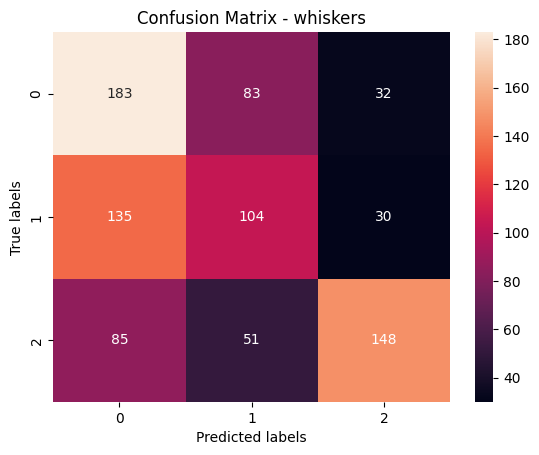

In [ ]:
# make a confusion matrix
confusion = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)

lables = ['0','1','2']    
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - whiskers'); 
ax.xaxis.set_ticklabels(lables); ax.yaxis.set_ticklabels(lables);
plt.show()

In [ ]:
!zip -r model_3.zip model_3

  adding: model_3/ (stored 0%)
  adding: model_3/assets/ (stored 0%)
  adding: model_3/keras_metadata.pb (deflated 96%)
  adding: model_3/fingerprint.pb (stored 0%)
  adding: model_3/variables/ (stored 0%)
  adding: model_3/variables/variables.data-00000-of-00001 (deflated 19%)
  adding: model_3/variables/variables.index (deflated 68%)
  adding: model_3/saved_model.pb (deflated 90%)
